In [36]:
import joblib
joblib.cpu_count()
exp_path_name="WACA-IF"

In [79]:
# !pip install --upgrade pip

import os
from joblib import Parallel, delayed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
from sklearn.svm import OneClassSVM
from dataclasses import asdict
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns


# Global utitlity functions are in separate notebook
%run ./Classification_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")

print("Setup Complete")

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neural Networks utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER

In [80]:
import sklearn
sklearn.__dir__()
sklearn.__version__

'1.0.2'

In [81]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
        
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
    
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    window_size: int  # After resampling
    ocsvm_step_width: int  # After resampling
    scaler: str  # StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_OCSVM = ExperimentParameters(
    name="NAIVE-MINMAX_OCSVM",
    frequency=100,
    max_subjects=29,
    max_test_subjects=10,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    seconds_per_subject_train=210,
    seconds_per_subject_test=210,    
    window_size=250,
    ocsvm_step_width=250,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    ocsvm_kernel="rbf",
    ocsvm_nu=None,
    ocsvm_gamma=None,
    feature_cols=[
        "x_a",
        "y_a",
        "z_a",
        "x_g",
        "y_g",
        "z_g",
    ],
    exclude_subjects=[],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-MINMAX-OCSVM",
    scaler_global=False,
    ocsvm_nu=0.165,
    ocsvm_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="NAIVE-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=True,
    ocsvm_nu=0.153,
    ocsvm_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_OCSVM_125 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=125
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)


VALID_ROBUST_OCSVM_250 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=250
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_500 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=500
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_750 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=750
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1000 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1000
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1250 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1250
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1500 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1500
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1750 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1750
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_2000 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=2000
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

# NORMALIZER_APPROACH (VALID)
# -----------------------------------------------------------
VALID_NORMALIZER_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-NORMALIZER-OCSVM",
    scaler="Normalizer",
    scaler_global=False,
    ocsvm_nu=0.074,
    ocsvm_gamma= 0.029,
)

In [82]:
P = VALID_ROBUST_OCSVM_2000
P.ocsvm_step_width = int(P.window_size * .5)
P.classifier="IF"

P.train_cores=1 # 20 cores for every user and 1 core for the nested crossval function
P.test_cores=2 # 10 cores for every user and 2 for the nested crossval function

# param_dist
param_dist = {
    "model__n_estimators": np.linspace(50, 200, num=10, dtype=np.int64),
    'model__max_samples':  np.arange(0.1, 1.1, 0.1),
    'model__contamination': np.arange(0.01, 0.11, 0.01),
    'model__max_features': np.arange(0.1, 1.1, 0.1),
    # 'model__bootstrap': [True, False], 
    }

param_dist = {
    "model__n_estimators": [10],
    'model__max_samples':  np.arange(0.1, 1.1, 0.1),
    'model__contamination': np.arange(0.01, 0.11, 0.01),
    'model__max_features': np.arange(0.1, 1.1, 0.1),
    # 'model__bootstrap': [True, False], 
    }

In [83]:
param_dist

{'model__n_estimators': [10],
 'model__max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'model__contamination': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
 'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

In [84]:
utils_ppp(P)

,Value
name,VALID-ROBUST-OCSVM
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [85]:
utils_eer_scorer

make_scorer(utils_eer, greater_is_better=False)

In [86]:
#include 47 later
# user_ids = [9]
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
raw_dfList_exp1, raw_dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997
2) accel_count: 26010, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24860, gyro_count: 26105
5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21975, gyro_count: 21658
19) accel_count: 24110, gyro_count: 25050
21) accel_count: 24326, gyro_count: 23809
22) accel_count: 29123, gyro_count: 28724
26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23457
35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24228, gyro_count: 24208
37) accel_count: 31945, gyro_count: 31816
38) accel_count: 22135, gyro_count: 22327
39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296
41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328
43) accel_count: 22631,

# Butterworth+EMA

<AxesSubplot:>

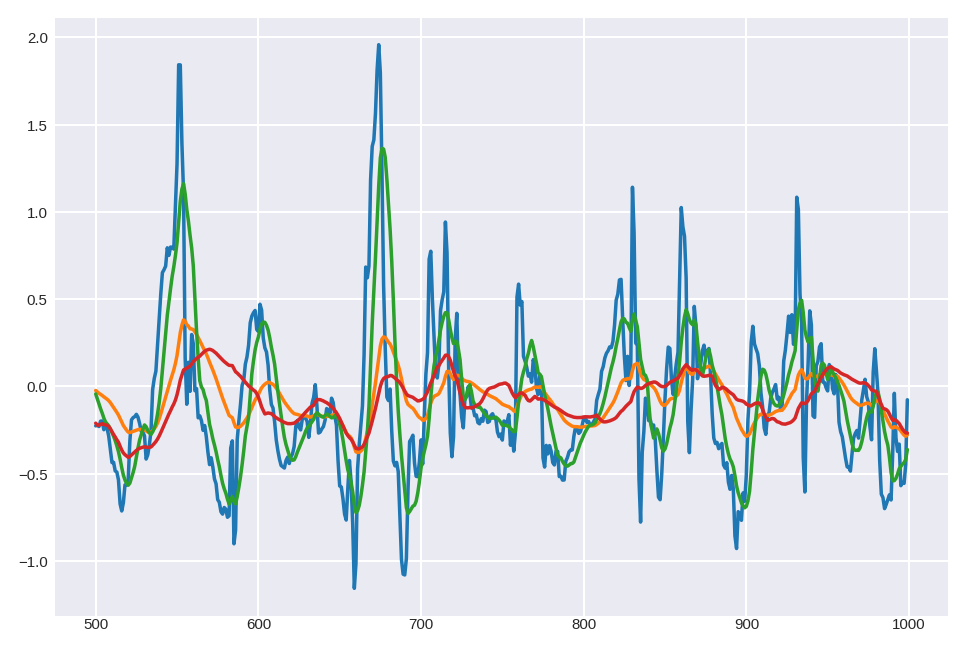

In [87]:
P.span=49
P.smoothing = "FFT+EMA"
# raw_dfList_exp1 = dfList_exp1
# raw_dfList_exp2 = dfList_exp2
P.cut_off_freq=42
ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2[0]['x_a'][500:1000].plot()
EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
EMAed_dfList_exp2[0]['x_a'][500:1000].plot()

dfList_exp1 = ffted_dfList_exp1
dfList_exp2 = ffted_dfList_exp2

dfList_exp1 =EMAed_dfList_exp1
dfList_exp2 =EMAed_dfList_exp2

SMAed_dfList_exp1 = get_SMAed_dfList(ffted_dfList_exp1, winsize=10)
SMAed_dfList_exp2 = get_SMAed_dfList(ffted_dfList_exp2, winsize=10)
SMAed_dfList_exp2[0]['x_a'][500:1000].plot()

raw_dfList_exp2[0]['x_a'][500:1000].rolling(window=50, min_periods=0).mean().plot()

In [88]:
i=0
raw_dfList_exp2[i]['x_a'][500:1000].rolling(window=10, min_periods=0, closed="both").mean()

500   -0.211201
501   -0.222568
502   -0.222900
503   -0.217521
504   -0.214294
         ...   
995   -0.480356
996   -0.468062
997   -0.455767
998   -0.438447
999   -0.388494
Name: x_a, Length: 500, dtype: float64

In [89]:
raw_dfList_exp2[i]['x_a'][500:1000]

500   -0.211201
501   -0.233935
502   -0.223566
503   -0.201385
504   -0.201385
         ...   
995   -0.557577
996   -0.557577
997   -0.557577
998   -0.437594
999   -0.096048
Name: x_a, Length: 500, dtype: float32

In [90]:
# i=0
# dfList_exp1[i][['x_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['y_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['z_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['x_g']].plot(figsize=(30, 6))
# dfList_exp1[i][['y_g']].plot(figsize=(30, 6))
# dfList_exp1[i][['z_g']].plot(figsize=(30, 6))

# dfList_exp2[i][['x_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['y_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['z_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['x_g']].plot(figsize=(30, 6))
# dfList_exp2[i][['y_g']].plot(figsize=(30, 6))
# dfList_exp2[i][['z_g']].plot(figsize=(30, 6))
# exp1 idx 10 has corrupted data frist 50 sec
# exp2 idx 12 has some artifacts first 12.5 sec
# exp1 idx 17 has some artifacts first 75 sec
# exp2 idx 23 has some artifacts last 6.5 sec

In [91]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
# train_set = randomized_data_idx
print(f"train_set: {train_set}\ntest_set: {test_set}")
# train_set = test_set
# test_set = train_set
print(f"train_set: {train_set}\ntest_set: {test_set}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226
Loading exp2 data:
47) accel_count: 17718, gyro_count: 18353


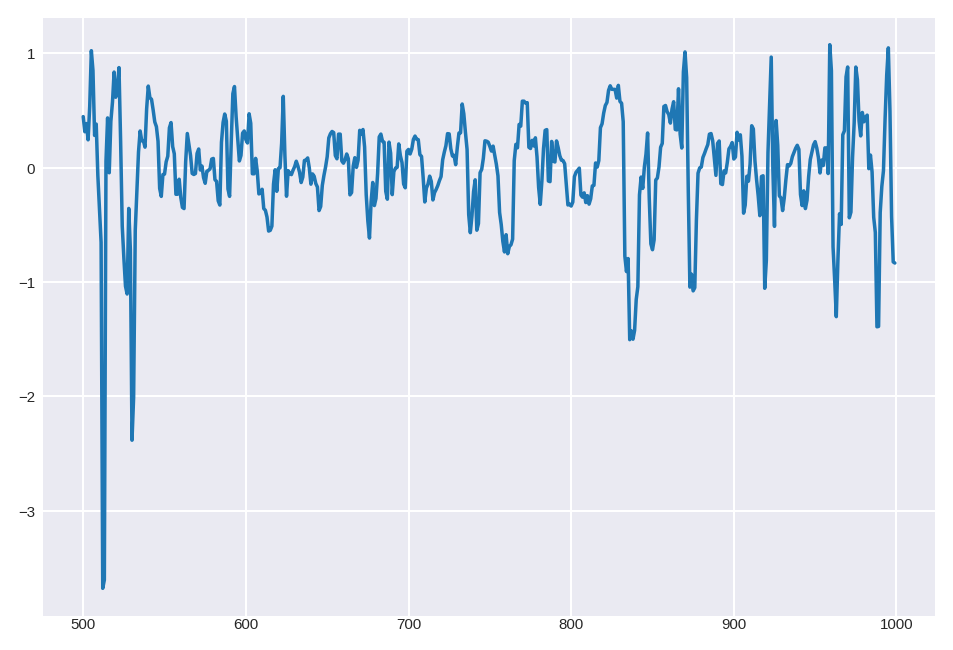

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
user_47_idx: 29
np.unique(all_user_set): [ 1  2  3  4  5  6  7  8 19 21 22 26 27 28 29 35 36 37 38 39 40 41 42 43
 44 45 46 48 49]
X_exp1_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
X_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
fitted_scaler_

In [92]:
num_sample_points_per_exp_user_47 = 18000
df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

raw_dfList_exp1_user_47 = dfList_exp1_user_47
raw_dfList_exp2_user_47 = dfList_exp2_user_47

ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47[0]['x_a'][500:1000].plot()

dfList_exp1_user_47 = ffted_dfList_exp1_user_47
dfList_exp2_user_47 = ffted_dfList_exp2_user_47

# EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
# EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
# EMAed_dfList_exp2_user_47[0]['EMA_x_a'][500:1000].plot()

# dfList_exp1_user_47 = EMAed_dfList_exp1_user_47
# dfList_exp2_user_47 = EMAed_dfList_exp2_user_47

%run ./utility-functions.ipynb


# preparing train data
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.ocsvm_step_width, train_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, P.window_size, P.ocsvm_step_width, 
                                                                                                                    scaler=P.scaler, num_sample_points_per_exp=P.num_sample_points_per_exp, 
                                                                                                                    EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
                                                                                           X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

print(f"len(exp1_df_train_dict): {len(X_train_exp1_dict)}")
print(f"len(exp2_df_train_dict): {len(X_train_exp2_dict)}")


# preparing test data
X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.ocsvm_step_width, test_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

print(f"len(X_test_exp1_dict): {len(X_test_exp1_dict)}")
print(f"len(X_test_exp2_dict): {len(X_test_exp2_dict)}")

In [93]:
print(f"train_set: {train_set}")
# print(f"X_exp1_train_dic: {X_exp1_train_dic.keys()}")
# print(f"X_exp2_train_dic: {X_exp2_train_dic.keys()}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]


In [94]:
print(f"test_set: {test_set}")
# print(f"X_exp1_test_dic: {X_exp1_test_dic.keys()}")
# print(f"X_exp2_test_dic: {X_exp2_test_dic.keys()}")

test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [52]:
# OCSVM_test_train_WACA_features_dic[0].shape

In [53]:
# plot_EER_distro(Mean_EER_df, 500)

In [54]:
train_set
P.user_ids
P.scaler="RobustScaler"

In [95]:
P.Butter_per_win_argdict={
                        "filter_order": 10,
                        "cut_off_freq": 27,
                        "sampling_freq": 100,
                        "filtfilt": 1,
                        }
train_set[:-19]
P.Butter_per_win_argdict=None
P.EMA_per_win_span=None
P.SMA_per_win_winsize=None
fitted_scaler_train_exp2_dict_user_47
fitted_scaler_train_exp2_dict

{7: RobustScaler(),
 24: RobustScaler(),
 8: RobustScaler(),
 11: RobustScaler(),
 13: RobustScaler(),
 19: RobustScaler(),
 28: RobustScaler(),
 21: RobustScaler(),
 26: RobustScaler(),
 3: RobustScaler(),
 20: RobustScaler(),
 22: RobustScaler(),
 6: RobustScaler(),
 25: RobustScaler(),
 16: RobustScaler(),
 1: RobustScaler(),
 17: RobustScaler(),
 27: RobustScaler(),
 5: RobustScaler(),
 29: RobustScaler()}

In [ ]:
overlap=.5
window_size=2000
step_width = int(window_size * (1-overlap))
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, window_size, step_width, train_set, P.scaler, P.num_sample_points_per_exp, 
                                                                                    EMA_per_win_span=P.EMA_per_win_span, SMA_per_win_winsize=P.SMA_per_win_winsize, 
                                                                                    Butter_per_win_argdict=P.Butter_per_win_argdict)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, window_size, step_width, scaler=P.scaler, 
                                                                                                                    num_sample_points_per_exp=P.num_sample_points_per_exp, 
                                                                                                                    EMA_per_win_span=P.EMA_per_win_span, SMA_per_win_winsize=P.SMA_per_win_winsize, 
                                                                                                                    Butter_per_win_argdict=P.Butter_per_win_argdict)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
                                                                                           X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

X_exp_train_dic = extract_WACA_features(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict)



In [57]:
dfList_dict={"dfList_exp1": raw_dfList_exp1,
            "dfList_exp2": raw_dfList_exp2,
            "dfList_exp1_user_47": raw_dfList_exp1_user_47,
            "dfList_exp2_user_47": raw_dfList_exp2_user_47,}


In [58]:
utils_plot_acc_eer_dist_thesis(EER_distro_df, "EER", 500, save_file_name=None, boxplot_color="lightcyan")


NameError: name 'EER_distro_df' is not defined

In [ ]:
utils_plot_acc_eer_dist_thesis(EER_distro_df, "EER", 500, save_file_name=None, boxplot_color="lightcyan")


In [67]:
# EER_distro_df
param_dist
# dfList_dict

{'model__n_estimators': [10],
 'model__max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'model__contamination': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
 'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

In [ ]:
assert EER_distro_df.median_nu.item() == EER_distro_df.median_nu.iloc[0]
EER_distro_df.median_gamma.item()

In [73]:
P.classifier

'IF'

In [97]:
a = evaluate_owner_classifier_train_valid(7, X_exp_train_dic, SEED, 0, param_dist, cores=1, exp_config=P, verbose=0) 


In [100]:
# len(EER_distro_df[EER_distro_df.owner==29])

P.Butter_per_win_argdict={
                        "filter_order": 10,
                        "cut_off_freq": 49,
                        "sampling_freq": 100,
                        "filtfilt": 1,
                        }
P.EMA_per_win_span=None
P.SMA_per_win_winsize=None
P.Butter_per_win_argdict=None
calculate_EER_different_window_sizes_train_OCSVM_IF_LOF

EER_distro_df=calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst=[2000], train_set=train_set, exp_config=P, 
                                                                      extract_features_func=extract_WACA_features, overlap=.5, param_dist=param_dist, verbose=0)

# best_param_df=pd.DataFrame([[2000, 19]], columns=["window_size", "best_n_neighbors"])
# EER_distro_df=calculate_EER_different_window_sizes_test_OCSVM_IF_LOF(dfList_dict, window_size_lst=[2000], test_set=test_set, exp_config=P, overlap=.5, best_param_df=best_param_df)

  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17


  0%|          | 0/1 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
EER_distro_df

In [76]:
P.Butter_per_win_argdict={
                        "filter_order": 10,
                        "cut_off_freq": 49,
                        "sampling_freq": 100,
                        "filtfilt": 1,
                        }
P.EMA_per_win_span=None
P.SMA_per_win_winsize=None
type(dfList_exp1)

list

ERROR! Session/line number was not unique in database. History logging moved to new session 872


In [31]:
EER_df_train_dict[P.cut_off_freq]

NameError: name 'EER_df_train_dict' is not defined

In [ ]:
np.arange(1,20) 
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [ ]:
assert EER_df_train_dict[P.cut_off_freq][EER_df_train_dict[P.cut_off_freq].window_size==1000].median_nu.item() == P.median_nu

In [ ]:
assert EER_df_train_dict[P.cut_off_freq].median_nu.item() == P.median_nu
assert EER_df_train_dict[P.cut_off_freq].median_gamma.item() == P.median_gamma

# 1. Butterworth frequency Cut-off

## 1.1 Naive Approach
### Optimizing and Testing

In [101]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butterworth"

window_size_lst = [2000]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
preprocessing_method="Naive"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
train_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_train_dict.txt"
test_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict.txt"
with open(train_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
    f.write("\n" + "-"*40 + f"{train_file_name}" + "-"*40 + "\n")
    
with open(test_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
    f.write("\n" + "-"*40 + f"{test_file_name}" + "-"*40 + "\n")
    


P.SMA_per_win_winsize=None
P.EMA_per_win_span=None
P.Butter_per_win_argdict=None
P.cut_off_freq=None
P.winsize=None
P.span=None

filter_order=10
sampling_freq=100
filtfilt=1

overlap=0.5
EER_df_train_dict={}
EER_df_test_dict={}
for cut_off_freq in tqdm(list(range(48, 50))):
    P.cut_off_freq=cut_off_freq
    print(f"cut_off_freq: {P.cut_off_freq}")

    
    ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)
    
    ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)

    
    dfList_dict={
                "dfList_exp1": ffted_dfList_exp1,
                "dfList_exp2": ffted_dfList_exp2,
                "dfList_exp1_user_47": ffted_dfList_exp1_user_47,
                "dfList_exp2_user_47": ffted_dfList_exp2_user_47
    }
    

    EER_df_train_dict[P.cut_off_freq] = calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst, train_set=train_set, exp_config=P, 
                                                                                                    extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                                    param_dist=param_dist)

    
    EER_df_test_dict[P.cut_off_freq] = calculate_EER_different_window_sizes_test_OCSVM_IF_LOF(dfList_dict, window_size_lst, test_set=test_set, exp_config=P, 
                                                                                          extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                          best_param_df=EER_df_train_dict[P.cut_off_freq])
        
    with open(train_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq: {P.cut_off_freq}\n")
        f.write(EER_df_train_dict[P.cut_off_freq].to_string())

    
    with open(test_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq: {P.cut_off_freq}\n")
        f.write(EER_df_test_dict[P.cut_off_freq].to_string())


        
mean_EER_train_dict={}
for key in EER_df_train_dict:
    mean_EER_train_dict[key] = EER_df_train_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_train_dict.items())
l.sort(key=lambda i: i[1])

with open(train_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")
        

mean_EER_test_dict={}
for key in EER_df_test_dict:
    mean_EER_test_dict[key] = EER_df_test_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_test_dict.items())
l.sort(key=lambda i: i[1])

with open(test_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 47]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


  0%|          | 0/2 [00:00<?, ?it/s]

cut_off_freq: 48



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  2.973216764628887
MakeWACAXExpDicUnknown Time:  7.528228851035237
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 15174.76it/s]


 33%|███▎      | 1/3 [00:32<01:05, 32.89s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 29056.49it/s]


 67%|██████▋   | 2/3 [01:05<00:32, 32.91s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 14734.95it/s]


100%|██████████| 3/3 [01:38<00:00, 32.94s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 15566.17it/s]


 20%|██        | 1/5 [00:01<00:05,  1.30s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 16116.44it/s]


 40%|████      | 2/5 [00:02<00:03,  1.27s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15697.25it/s]


 60%|██████    | 3/5 [00:03<00:02,  1.22s/it]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 26206.21it/s]


 80%|████████  | 4/5 [00:04<00:01,  1.20s/it]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 9121.03it/s]


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]

100%|██████████| 1/1 [01:55<00:00, 115.79s/it]



window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.7975586280226707
MakeWACAXExpDicUnknown Time:  3.222247365862131
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 25396.94it/s]


 20%|██        | 1/5 [00:01<00:05,  1.43s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 14478.09it/s]


 40%|████      | 2/5 [00:02<00:04,  1.42s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 7380.44it/s]


 60%|██████    | 3/5 [00:04<00:02,  1.42s/it]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 13684.52it/s]


 80%|████████  | 4/5 [00:05<00:01,  1.44s/it]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 13974.03it/s]


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]

 50%|█████     | 1/2 [02:08<02:08, 128.77s/it]

cut_off_freq: 49



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  2.048815442249179
MakeWACAXExpDicUnknown Time:  7.417144713923335
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 15926.73it/s]


 33%|███▎      | 1/3 [00:32<01:05, 32.90s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 14254.22it/s]


 67%|██████▋   | 2/3 [01:05<00:32, 32.90s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 18493.40it/s]


100%|██████████| 3/3 [01:38<00:00, 32.89s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 18493.40it/s]


 20%|██        | 1/5 [00:01<00:05,  1.40s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 10822.61it/s]


 40%|████      | 2/5 [00:02<00:04,  1.34s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 14958.29it/s]


 60%|██████    | 3/5 [00:03<00:02,  1.30s/it]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 16073.21it/s]


 80%|████████  | 4/5 [00:05<00:01,  1.30s/it]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 18016.77it/s]


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]

100%|██████████| 1/1 [01:55<00:00, 115.08s/it]


window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.759185316041112
MakeWACAXExpDicUnknown Time:  3.1381986159831285
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 17249.86it/s]


 20%|██        | 1/5 [00:01<00:06,  1.55s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 10948.33it/s]


 40%|████      | 2/5 [00:03<00:04,  1.55s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15177.51it/s]


 60%|██████    | 3/5 [00:04<00:03,  1.53s/it]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 14724.61it/s]


 80%|████████  | 4/5 [00:06<00:01,  1.52s/it]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 19152.07it/s]


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]

100%|██████████| 2/2 [04:17<00:00, 128.58s/it]


In [102]:
EER_df_train_dict[P.cut_off_freq]


,window_size,step_width,Mean_EER,median_n_estimators,median_max_samples,median_contamination,median_max_features
0,2000,1000,0.272711,10,0.7,0.06,0.5


## 1.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

In [35]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butterworth"

window_size_lst = [2000]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
preprocessing_method="Realworld-per_unknown_window"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
train_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_train_dict.txt"
test_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict.txt"
with open(train_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
with open(test_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
    

P.SMA_per_win_winsize=None
P.EMA_per_win_span=None
P.Butter_per_win_argdict=None
P.cut_off_freq=None
P.winsize=None
P.span=None

filter_order=10
sampling_freq=100
filtfilt=1

P.Butter_per_win_argdict={
    "filter_order": filter_order,
    "cut_off_freq": None,
    "sampling_freq": sampling_freq,
    "filtfilt": filtfilt,
    }

overlap=0.5
EER_df_train_dict={}
EER_df_test_dict={}

for cut_off_freq in tqdm(list(range(48, 50))):
    P.cut_off_freq=cut_off_freq
    P.Butter_per_win_argdict["cut_off_freq"]=cut_off_freq
    print(f"cut_off_freq: {P.cut_off_freq}")

    
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)
    
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)

    
    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": ffted_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": ffted_dfList_exp2_user_47
    }
    

    EER_df_train_dict[P.cut_off_freq] = calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst, train_set=train_set, exp_config=P, 
                                                                                                    extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                                    param_dist=param_dist)

    EER_df_test_dict[P.cut_off_freq] = calculate_EER_different_window_sizes_test_OCSVM_IF_LOF(dfList_dict, window_size_lst, test_set=test_set, exp_config=P, 
                                                                                          extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                          best_param_df=EER_df_train_dict[P.cut_off_freq])
        
    with open(train_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq: {P.cut_off_freq}\n")
        f.write(EER_df_train_dict[P.cut_off_freq].to_string())

    
    with open(test_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq: {P.cut_off_freq}\n")
        f.write(EER_df_test_dict[P.cut_off_freq].to_string())



mean_EER_train_dict={}
for key in EER_df_train_dict:
    mean_EER_train_dict[key] = EER_df_train_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_train_dict.items())
l.sort(key=lambda i: i[1])

with open(train_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")
        

mean_EER_test_dict={}
for key in EER_df_test_dict:
    mean_EER_test_dict[key] = EER_df_test_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_test_dict.items())
l.sort(key=lambda i: i[1])

with open(test_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 47]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


NameError: name 'exp_path_name' is not defined

# 2. Butterworth frequency Cut-off + EMA span
## 2.1 Naive Approach
### Optimizing and Testing

In [62]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butter+EMA"

window_size_lst = [2000]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
preprocessing_method="Naive"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
train_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_train_dict.txt"
test_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict.txt"
with open(train_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
with open(test_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
    
indices = list(range(1, 50))
mesh = np.array(np.meshgrid(indices, indices))
index_pairs = mesh.T.reshape(-1, 2)
choice_num=240
print(f"total cut_off_span_pairs: {index_pairs.shape}, choice_num: {choice_num}")
cut_off_span_pairs = index_pairs[np.random.choice(index_pairs.shape[0], size=240, replace=False), :]

P.SMA_per_win_winsize=None
P.EMA_per_win_span=None
P.Butter_per_win_argdict=None
P.cut_off_freq=None
P.winsize=None
P.span=None

filter_order=10
sampling_freq=100
filtfilt=1

overlap=0.5
EER_df_train_dict={}
EER_df_test_dict={}

for key_pair in tqdm(cut_off_span_pairs[-2:]):
    
    key_pair = tuple(key_pair)
    cut_off_freq, span = key_pair[0], key_pair[1]
    P.cut_off_freq=cut_off_freq
    P.span=span
    print(f"cut_off_freq: {P.cut_off_freq}")
    print(f"span: {P.span}")

    
    ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)

    EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
    EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
    
    ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)

    EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
    EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
    
    dfList_dict={
                "dfList_exp1": EMAed_dfList_exp1,
                "dfList_exp2": EMAed_dfList_exp2,
                "dfList_exp1_user_47": EMAed_dfList_exp1_user_47,
                "dfList_exp2_user_47": EMAed_dfList_exp2_user_47
    }
    

    EER_df_train_dict[key_pair] = calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst, train_set=train_set, exp_config=P, 
                                                                                      extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                      param_dist=param_dist)

    EER_df_test_dict[key_pair] = calculate_EER_different_window_sizes_test_OCSVM_IF_LOF(dfList_dict, window_size_lst, test_set=test_set, exp_config=P, 
                                                                                    extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                    best_param_df=EER_df_train_dict[key_pair])
        
    with open(train_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq, span: {key_pair}\n")
        f.write(EER_df_train_dict[key_pair].to_string())

    
    with open(test_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq, span: {key_pair}\n")
        f.write(EER_df_test_dict[key_pair].to_string())


        
mean_EER_train_dict={}
for key in EER_df_train_dict:
    mean_EER_train_dict[key] = EER_df_train_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_train_dict.items())
l.sort(key=lambda i: i[1])

with open(train_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")
        

mean_EER_test_dict={}
for key in EER_df_test_dict:
    mean_EER_test_dict[key] = EER_df_test_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_test_dict.items())
l.sort(key=lambda i: i[1])

with open(test_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")
        

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 47]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
total cut_off_span_pairs: (2401, 2), choice_num: 240


  0%|          | 0/2 [00:00<?, ?it/s]

cut_off_freq: 38
span: 4



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  3.0066315177828074
MakeWACAXExpDicUnknown Time:  6.507947504520416
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 18889.01it/s]


 33%|███▎      | 1/3 [00:04<00:09,  4.56s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 17133.59it/s]


 67%|██████▋   | 2/3 [00:09<00:04,  4.63s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 11161.00it/s]


100%|██████████| 3/3 [00:13<00:00,  4.60s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 14077.21it/s]


 20%|██        | 1/5 [00:00<00:03,  1.18it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 9275.33it/s]


 40%|████      | 2/5 [00:01<00:02,  1.20it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 19944.38it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.26it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 16247.55it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.30it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 21383.15it/s]


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]

100%|██████████| 1/1 [00:27<00:00, 27.57s/it]

 

window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.7392341047525406
MakeWACAXExpDicUnknown Time:  2.872464908286929
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 17060.42it/s]


 20%|██        | 1/5 [00:00<00:03,  1.27it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 12185.66it/s]


 40%|████      | 2/5 [00:01<00:02,  1.27it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 16364.82it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.28it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 16558.64it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.28it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 15941.86it/s]


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

 50%|█████     | 1/2 [00:37<00:37, 37.07s/it]

cut_off_freq: 29
span: 13



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  2.1274465769529343
MakeWACAXExpDicUnknown Time:  6.27242805249989
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 8089.30it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.41s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 7740.71it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.46s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 14841.84it/s]


100%|██████████| 3/3 [00:13<00:00,  4.43s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 16637.46it/s]


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 15060.34it/s]


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 16875.09it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.26it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 10684.76it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.25it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 14982.33it/s]


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]

100%|██████████| 1/1 [00:26<00:00, 26.48s/it]

  

window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.7376858964562416
MakeWACAXExpDicUnknown Time:  2.6812961641699076
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 16817.58it/s]


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 27077.50it/s]


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15391.94it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.29it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 8576.43it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.27it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 14310.15it/s]


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

100%|██████████| 2/2 [01:12<00:00, 36.48s/it]


## 2.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

In [63]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butter+EMA"


window_size_lst = [2000]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
preprocessing_method="Realworld-per_unknown_window"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
train_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_train_dict.txt"
test_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict.txt"
with open(train_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
with open(test_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
    
indices = list(range(1, 50))
mesh = np.array(np.meshgrid(indices, indices))
index_pairs = mesh.T.reshape(-1, 2)
choice_num=240
print(f"total cut_off_span_pairs: {index_pairs.shape}, choice_num: {choice_num}")
cut_off_span_pairs = index_pairs[np.random.choice(index_pairs.shape[0], size=240, replace=False), :]

P.SMA_per_win_winsize=None
P.EMA_per_win_span=None
P.Butter_per_win_argdict=None
P.cut_off_freq=None
P.winsize=None
P.span=None

filter_order=10
sampling_freq=100
filtfilt=1
P.Butter_per_win_argdict={
    "filter_order": filter_order,
    "cut_off_freq": None,
    "sampling_freq": sampling_freq,
    "filtfilt": filtfilt,
    }

overlap=0.5
EER_df_train_dict={}
EER_df_test_dict={}

for key_pair in tqdm(cut_off_span_pairs[-2:]):
    key_pair = tuple(key_pair)
    cut_off_freq, span = key_pair[0], key_pair[1]
    P.cut_off_freq=cut_off_freq
    P.Butter_per_win_argdict["cut_off_freq"]=cut_off_freq
    
    
    P.span=span
    P.EMA_per_win_span=span

    print(f"cut_off_freq: {P.cut_off_freq}")
    print(f"span: {P.span}")

    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)
    EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
    
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)
    EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
    
    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": EMAed_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": EMAed_dfList_exp2_user_47
    }
    

    EER_df_train_dict[key_pair] = calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst, train_set=train_set, exp_config=P, 
                                                                                      extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                      param_dist=param_dist)

    EER_df_test_dict[key_pair] = calculate_EER_different_window_sizes_test_OCSVM_IF_LOF(dfList_dict, window_size_lst, test_set=test_set, exp_config=P, 
                                                                                    extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                    best_param_df=EER_df_train_dict[key_pair])
        
    with open(train_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq, span: {key_pair}\n")
        f.write(EER_df_train_dict[key_pair].to_string())

    
    with open(test_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq, span: {key_pair}\n")
        f.write(EER_df_test_dict[key_pair].to_string())


        
mean_EER_train_dict={}
for key in EER_df_train_dict:
    mean_EER_train_dict[key] = EER_df_train_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_train_dict.items())
l.sort(key=lambda i: i[1])

with open(train_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")
        

mean_EER_test_dict={}
for key in EER_df_test_dict:
    mean_EER_test_dict[key] = EER_df_test_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_test_dict.items())
l.sort(key=lambda i: i[1])

with open(test_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 47]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
total cut_off_span_pairs: (2401, 2), choice_num: 240


  0%|          | 0/2 [00:00<?, ?it/s]

cut_off_freq: 38
span: 4



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  1.9965347480028868
MakeWACAXExpDicUnknown Time:  7.562829148024321
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 7180.80it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.48s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 12499.79it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.47s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15246.47it/s]


100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 16640.76it/s]


 20%|██        | 1/5 [00:00<00:03,  1.22it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 14789.51it/s]


 40%|████      | 2/5 [00:01<00:02,  1.21it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 24364.24it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 16594.67it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.26it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 15372.20it/s]


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]

100%|██████████| 1/1 [00:32<00:00, 32.75s/it]

 

window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.7248636614531279
MakeWACAXExpDicUnknown Time:  3.0679730121046305
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 20365.64it/s]


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 17916.72it/s]


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 32463.65it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 15344.08it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.20it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 8400.37it/s]


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

 50%|█████     | 1/2 [00:44<00:44, 44.53s/it]

cut_off_freq: 29
span: 13



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  1.9737008977681398
MakeWACAXExpDicUnknown Time:  7.502977570518851
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 13792.52it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.46s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 14505.63it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.48s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15869.48it/s]


100%|██████████| 3/3 [00:13<00:00,  4.50s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 17267.62it/s]


 20%|██        | 1/5 [00:00<00:03,  1.13it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 13955.43it/s]


 40%|████      | 2/5 [00:01<00:02,  1.13it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 20111.74it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 17787.55it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 19004.55it/s]


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

100%|██████████| 1/1 [00:32<00:00, 32.85s/it]



window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.7279952988028526
MakeWACAXExpDicUnknown Time:  3.0203619692474604
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 12873.86it/s]


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 15791.81it/s]


 40%|████      | 2/5 [00:01<00:02,  1.17it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 14013.71it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 18259.92it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.19it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 12671.61it/s]


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

100%|██████████| 2/2 [01:29<00:00, 44.60s/it]


# 3. EMA span
## 3.1 Naive Approach
### Optimizing and Testing

In [64]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "EMA"


window_size_lst = [2000]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
preprocessing_method="Naive"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
train_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_train_dict.txt"
test_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict.txt"
with open(train_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
with open(test_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
    

P.SMA_per_win_winsize=None
P.EMA_per_win_span=None
P.Butter_per_win_argdict=None
P.cut_off_freq=None
P.winsize=None
P.span=None


overlap=0.5
EER_df_train_dict={}
EER_df_test_dict={}
for span in tqdm(list(range(48, 50))):
    P.span=span
    print(f"EMA span: {P.span}")

    
    EMAed_dfList_exp1 = get_EMAed_dfList(raw_dfList_exp1, span=P.span)
    EMAed_dfList_exp2 = get_EMAed_dfList(raw_dfList_exp2, span=P.span)
    
    EMAed_dfList_exp1_user_47 = get_EMAed_dfList(raw_dfList_exp1_user_47, span=P.span)
    EMAed_dfList_exp2_user_47 = get_EMAed_dfList(raw_dfList_exp2_user_47, span=P.span)

    
    dfList_dict={
                "dfList_exp1": EMAed_dfList_exp1,
                "dfList_exp2": EMAed_dfList_exp2,
                "dfList_exp1_user_47": EMAed_dfList_exp1_user_47,
                "dfList_exp2_user_47": EMAed_dfList_exp2_user_47
    }
    

    EER_df_train_dict[P.span] = calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst, train_set=train_set, exp_config=P, 
                                                                                    extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                    param_dist=param_dist)

    EER_df_test_dict[P.span] = calculate_EER_different_window_sizes_test_OCSVM_IF_LOF(dfList_dict, window_size_lst, test_set=test_set, exp_config=P, 
                                                                                  extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                  best_param_df=EER_df_train_dict[P.span])
        
    with open(train_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\EMA span: {P.span}\n")
        f.write(EER_df_train_dict[P.span].to_string())

    
    with open(test_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\EMA span: {P.span}\n")
        f.write(EER_df_test_dict[P.span].to_string())


        
mean_EER_train_dict={}
for key in EER_df_train_dict:
    mean_EER_train_dict[key] = EER_df_train_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_train_dict.items())
l.sort(key=lambda i: i[1])

with open(train_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")
        

mean_EER_test_dict={}
for key in EER_df_test_dict:
    mean_EER_test_dict[key] = EER_df_test_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_test_dict.items())
l.sort(key=lambda i: i[1])

with open(test_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 47]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


  0%|          | 0/2 [00:00<?, ?it/s]

EMA span: 48



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  1.93345607817173
MakeWACAXExpDicUnknown Time:  6.26782513782382
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 7921.25it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.44s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 13890.72it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.47s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 17560.41it/s]


100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 16438.58it/s]


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 12208.71it/s]


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 17840.51it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.26it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 28591.03it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.26it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 15403.25it/s]


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

100%|██████████| 1/1 [00:25<00:00, 25.96s/it]

 

window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.6865684408694506
MakeWACAXExpDicUnknown Time:  2.7143782898783684
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 14230.04it/s]


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 13033.88it/s]


 40%|████      | 2/5 [00:01<00:02,  1.16it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 7739.28it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 9722.54it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.19it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 11129.90it/s]


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

 50%|█████     | 1/2 [00:34<00:34, 34.12s/it]

EMA span: 49



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  1.9561785906553268
MakeWACAXExpDicUnknown Time:  6.247812470421195
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 11513.32it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.46s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 22988.79it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.50s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 14213.16it/s]


100%|██████████| 3/3 [00:13<00:00,  4.50s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 16773.86it/s]


 20%|██        | 1/5 [00:00<00:03,  1.17it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 15180.25it/s]


 40%|████      | 2/5 [00:01<00:02,  1.15it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 18497.48it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 9500.12it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 18538.36it/s]


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

100%|██████████| 1/1 [00:26<00:00, 26.18s/it]

 

window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.6773153860121965
MakeWACAXExpDicUnknown Time:  2.730512548238039
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 14711.69it/s]


 20%|██        | 1/5 [00:00<00:03,  1.18it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 7601.82it/s]


 40%|████      | 2/5 [00:01<00:02,  1.14it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 16307.56it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 16169.25it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.18it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 15341.27it/s]


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

100%|██████████| 2/2 [01:08<00:00, 34.25s/it]


## 3.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

In [65]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "EMA"


window_size_lst = [2000]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
preprocessing_method="Realworld-per_unknown_window"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
train_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_train_dict.txt"
test_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict.txt"
with open(train_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
with open(test_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
    

P.SMA_per_win_winsize=None
P.EMA_per_win_span=None
P.Butter_per_win_argdict=None
P.cut_off_freq=None
P.winsize=None
P.span=None

overlap=0.5
EER_df_train_dict={}
EER_df_test_dict={}
for span in tqdm(list(range(48, 50))):
    P.span=span
    print(f"EMA span: {P.span}")

    P.EMA_per_win_span=P.span

    EMAed_dfList_exp2 = get_EMAed_dfList(raw_dfList_exp2, span=P.span)
    
    EMAed_dfList_exp2_user_47 = get_EMAed_dfList(raw_dfList_exp2_user_47, span=P.span)

    
    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": EMAed_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": EMAed_dfList_exp2_user_47
    }
    

    EER_df_train_dict[P.span] = calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst, train_set=train_set, exp_config=P, 
                                                                                    extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                    param_dist=param_dist)

    EER_df_test_dict[P.span] = calculate_EER_different_window_sizes_test_OCSVM_IF_LOF(dfList_dict, window_size_lst, test_set=test_set, exp_config=P, 
                                                                                  extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                  best_param_df=EER_df_train_dict[P.span])
        
    with open(train_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\EMA span: {P.span}\n")
        f.write(EER_df_train_dict[P.span].to_string())

    
    with open(test_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\EMA span: {P.span}\n")
        f.write(EER_df_test_dict[P.span].to_string())


        
mean_EER_train_dict={}
for key in EER_df_train_dict:
    mean_EER_train_dict[key] = EER_df_train_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_train_dict.items())
l.sort(key=lambda i: i[1])

with open(train_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")
        

mean_EER_test_dict={}
for key in EER_df_test_dict:
    mean_EER_test_dict[key] = EER_df_test_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_test_dict.items())
l.sort(key=lambda i: i[1])

with open(test_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 47]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


  0%|          | 0/2 [00:00<?, ?it/s]

EMA span: 48



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  1.9418525472283363
MakeWACAXExpDicUnknown Time:  7.289446542039514
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 9559.67it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.43s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 18224.22it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.42s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15659.15it/s]


100%|██████████| 3/3 [00:13<00:00,  4.45s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 15641.63it/s]


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 13060.26it/s]


 40%|████      | 2/5 [00:01<00:02,  1.15it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 9451.95it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.19it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 15095.57it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.27it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 16844.59it/s]


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

100%|██████████| 1/1 [00:27<00:00, 27.90s/it]

  

window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.946101164445281
MakeWACAXExpDicUnknown Time:  2.9604240749031305
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 11363.60it/s]


 20%|██        | 1/5 [00:00<00:03,  1.26it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 9105.19it/s]


 40%|████      | 2/5 [00:01<00:02,  1.20it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 21018.81it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 12967.40it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.19it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 13076.55it/s]


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

 50%|█████     | 1/2 [00:36<00:36, 36.82s/it]

EMA span: 49



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  1.9055927395820618
MakeWACAXExpDicUnknown Time:  7.347828555852175
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 12240.78it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.48s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 8897.55it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.50s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 13454.06it/s]


100%|██████████| 3/3 [00:13<00:00,  4.52s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 18319.74it/s]


 20%|██        | 1/5 [00:00<00:03,  1.30it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 16435.36it/s]


 40%|████      | 2/5 [00:01<00:02,  1.25it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 18554.76it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.27it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 15332.86it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.30it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 19700.82it/s]


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

100%|██████████| 1/1 [00:27<00:00, 28.00s/it]

 

window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.7312413100153208
MakeWACAXExpDicUnknown Time:  3.044450882822275
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 13680.05it/s]


 20%|██        | 1/5 [00:00<00:03,  1.17it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 17882.34it/s]


 40%|████      | 2/5 [00:01<00:02,  1.17it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 12436.78it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 15377.83it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 15929.75it/s]


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

100%|██████████| 2/2 [01:13<00:00, 36.76s/it]


# 4. SMA winsize
## 4.1 Naive Approach
### Optimizing and Testing

In [66]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "SMA"


window_size_lst = [2000]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
preprocessing_method="Naive"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
train_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_train_dict.txt"
test_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict.txt"
with open(train_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
with open(test_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
    

P.SMA_per_win_winsize=None
P.EMA_per_win_span=None
P.Butter_per_win_argdict=None
P.cut_off_freq=None
P.winsize=None
P.span=None


overlap=0.5
EER_df_train_dict={}
EER_df_test_dict={}
for winsize in tqdm(list(range(48, 50))):
    P.winsize=winsize
    print(f"SMA winsize: {P.winsize}")


    SMAed_dfList_exp1 = get_SMAed_dfList(raw_dfList_exp1, winsize=P.winsize)
    SMAed_dfList_exp2 = get_SMAed_dfList(raw_dfList_exp2, winsize=P.winsize)
    
    SMAed_dfList_exp1_user_47 = get_SMAed_dfList(raw_dfList_exp1_user_47, winsize=P.winsize)
    SMAed_dfList_exp2_user_47 = get_SMAed_dfList(raw_dfList_exp2_user_47, winsize=P.winsize)

    
    dfList_dict={
                "dfList_exp1": SMAed_dfList_exp1,
                "dfList_exp2": SMAed_dfList_exp2,
                "dfList_exp1_user_47": SMAed_dfList_exp1_user_47,
                "dfList_exp2_user_47": SMAed_dfList_exp2_user_47
    }
    

    EER_df_train_dict[P.winsize] = calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst, train_set=train_set, exp_config=P, 
                                                                                       extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                       param_dist=param_dist)

    EER_df_test_dict[P.winsize] = calculate_EER_different_window_sizes_test_OCSVM_IF_LOF(dfList_dict, window_size_lst, test_set=test_set, exp_config=P, 
                                                                                     extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                     best_param_df=EER_df_train_dict[P.winsize])
        
    with open(train_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\SMA winsize: {P.winsize}\n")
        f.write(EER_df_train_dict[P.winsize].to_string())

    
    with open(test_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\SMA winsize: {P.winsize}\n")
        f.write(EER_df_test_dict[P.winsize].to_string())


        
mean_EER_train_dict={}
for key in EER_df_train_dict:
    mean_EER_train_dict[key] = EER_df_train_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_train_dict.items())
l.sort(key=lambda i: i[1])

with open(train_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")
        

mean_EER_test_dict={}
for key in EER_df_test_dict:
    mean_EER_test_dict[key] = EER_df_test_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_test_dict.items())
l.sort(key=lambda i: i[1])

with open(test_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 47]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


  0%|          | 0/2 [00:00<?, ?it/s]

SMA winsize: 48



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  3.709948243573308
MakeWACAXExpDicUnknown Time:  7.450098142027855
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 4144.98it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.38s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 11199.74it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.51s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 14134.13it/s]


100%|██████████| 3/3 [00:13<00:00,  4.49s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 12007.74it/s]


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 17761.19it/s]


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15537.34it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 14122.24it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.26it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 13129.77it/s]


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

100%|██████████| 1/1 [00:29<00:00, 29.00s/it]

 

window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.8773576468229294
MakeWACAXExpDicUnknown Time:  2.8380726873874664
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 20836.09it/s]


 20%|██        | 1/5 [00:00<00:03,  1.19it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 12359.82it/s]


 40%|████      | 2/5 [00:01<00:02,  1.17it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 16677.15it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 13210.41it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 16159.91it/s]


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

 50%|█████     | 1/2 [00:37<00:37, 37.46s/it]

SMA winsize: 49



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  3.587797038257122
MakeWACAXExpDicUnknown Time:  7.395635528489947
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 8930.70it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.38s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 13751.82it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.43s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15299.30it/s]


100%|██████████| 3/3 [00:13<00:00,  4.43s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 20681.97it/s]


 20%|██        | 1/5 [00:00<00:03,  1.27it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 16368.02it/s]


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 14698.80it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 18141.45it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.26it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 13146.23it/s]


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

100%|██████████| 1/1 [00:28<00:00, 28.60s/it]

 

window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.903307368978858
MakeWACAXExpDicUnknown Time:  2.827775364741683
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 14583.81it/s]


 20%|██        | 1/5 [00:00<00:03,  1.16it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 9957.99it/s]


 40%|████      | 2/5 [00:01<00:02,  1.15it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 13918.38it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 25420.02it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 15756.21it/s]


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

100%|██████████| 2/2 [01:14<00:00, 37.27s/it]


## 4.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

In [67]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "SMA"


window_size_lst = [2000]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
preprocessing_method="Realworld-per_unknown_window"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
train_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_train_dict.txt"
test_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict.txt"
with open(train_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
with open(test_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
    

P.SMA_per_win_winsize=None
P.EMA_per_win_span=None
P.Butter_per_win_argdict=None
P.cut_off_freq=None
P.winsize=None
P.span=None


overlap=0.5
EER_df_train_dict={}
EER_df_test_dict={}
for winsize in tqdm(list(range(48, 50))):
    P.winsize=winsize
    P.SMA_per_win_winsize=P.winsize

    print(f"SMA winsize: {P.winsize}")


    SMAed_dfList_exp2 = get_SMAed_dfList(raw_dfList_exp2, winsize=P.winsize)
    
    SMAed_dfList_exp2_user_47 = get_SMAed_dfList(raw_dfList_exp2_user_47, winsize=P.winsize)

    
    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": SMAed_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": SMAed_dfList_exp2_user_47
    }
    

    EER_df_train_dict[P.winsize] = calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst, train_set=train_set, exp_config=P, 
                                                                                       extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                       param_dist=param_dist)

    EER_df_test_dict[P.winsize] = calculate_EER_different_window_sizes_test_OCSVM_IF_LOF(dfList_dict, window_size_lst, test_set=test_set, exp_config=P, 
                                                                                     extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                     best_param_df=EER_df_train_dict[P.winsize])
        
    with open(train_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\SMA winsize: {P.winsize}\n")
        f.write(EER_df_train_dict[P.winsize].to_string())

    
    with open(test_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\SMA winsize: {P.winsize}\n")
        f.write(EER_df_test_dict[P.winsize].to_string())


        
mean_EER_train_dict={}
for key in EER_df_train_dict:
    mean_EER_train_dict[key] = EER_df_train_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_train_dict.items())
l.sort(key=lambda i: i[1])

with open(train_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")
        

mean_EER_test_dict={}
for key in EER_df_test_dict:
    mean_EER_test_dict[key] = EER_df_test_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_test_dict.items())
l.sort(key=lambda i: i[1])

with open(test_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 47]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


  0%|          | 0/2 [00:00<?, ?it/s]

SMA winsize: 48



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  3.6181837804615498
MakeWACAXExpDicUnknown Time:  8.461150141432881
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 7522.07it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.43s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 14852.35it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.43s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 13133.88it/s]


100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 17285.41it/s]


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 14998.41it/s]


 40%|████      | 2/5 [00:01<00:02,  1.21it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15346.89it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 25010.76it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 15500.01it/s]


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]

100%|██████████| 1/1 [00:31<00:00, 31.18s/it]

 

window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.9347229767590761
MakeWACAXExpDicUnknown Time:  3.184860199689865
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 14839.21it/s]


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 9959.17it/s]


 40%|████      | 2/5 [00:01<00:02,  1.21it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 23334.10it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.17it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 28976.19it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.17it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 13754.07it/s]


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

 50%|█████     | 1/2 [00:40<00:40, 40.33s/it]

SMA winsize: 49



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  3.520819630473852
MakeWACAXExpDicUnknown Time:  8.704516761004925
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 11172.89it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.47s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 11250.82it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.50s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 13787.98it/s]


100%|██████████| 3/3 [00:13<00:00,  4.51s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 18404.14it/s]


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 14779.08it/s]


 40%|████      | 2/5 [00:01<00:02,  1.17it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 14081.93it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.28it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 15953.99it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.32it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 19436.07it/s]


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]

100%|██████████| 1/1 [00:30<00:00, 30.80s/it]



window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.8730015214532614
MakeWACAXExpDicUnknown Time:  3.149862376973033
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 11621.79it/s]


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 21161.98it/s]


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 19117.16it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 17738.65it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 11533.90it/s]


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

100%|██████████| 2/2 [01:20<00:00, 40.03s/it]


# 5. Butterworth frequency Cut-off + SMA winsize
## 5.1 Naive Approach
### Optimizing and Testin

In [68]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butter+SMA"


window_size_lst = [2000]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
preprocessing_method="Naive"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
train_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_train_dict.txt"
test_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict.txt"
with open(train_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
with open(test_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
    
indices = list(range(1, 50))
mesh = np.array(np.meshgrid(indices, indices))
index_pairs = mesh.T.reshape(-1, 2)
choice_num=240
print(f"total cut_off_winsize_pairs: {index_pairs.shape}, choice_num: {choice_num}")
cut_off_winsize_pairs = index_pairs[np.random.choice(index_pairs.shape[0], size=240, replace=False), :]

P.SMA_per_win_winsize=None
P.EMA_per_win_span=None
P.Butter_per_win_argdict=None
P.cut_off_freq=None
P.winsize=None
P.span=None

filter_order=10
sampling_freq=100
filtfilt=1

overlap=0.5
EER_df_train_dict={}
EER_df_test_dict={}

for key_pair in tqdm(cut_off_winsize_pairs[-2:]):
    
    key_pair = tuple(key_pair)
    cut_off_freq, winsize = key_pair[0], key_pair[1]
    P.cut_off_freq=cut_off_freq
    P.winsize=winsize
    print(f"cut_off_freq: {P.cut_off_freq}")
    print(f"winsize: {P.winsize}")

    
    ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)

    SMAed_dfList_exp1 = get_SMAed_dfList(ffted_dfList_exp1, winsize=P.winsize)
    SMAed_dfList_exp2 = get_SMAed_dfList(ffted_dfList_exp2, winsize=P.winsize)
    
    ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)

    SMAed_dfList_exp1_user_47 = get_SMAed_dfList(ffted_dfList_exp1_user_47, winsize=P.winsize)
    SMAed_dfList_exp2_user_47 = get_SMAed_dfList(ffted_dfList_exp2_user_47, winsize=P.winsize)
    
    dfList_dict={
                "dfList_exp1": SMAed_dfList_exp1,
                "dfList_exp2": SMAed_dfList_exp2,
                "dfList_exp1_user_47": SMAed_dfList_exp1_user_47,
                "dfList_exp2_user_47": SMAed_dfList_exp2_user_47
    }
    

    EER_df_train_dict[key_pair] = calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst, train_set=train_set, exp_config=P, 
                                                                                      extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                      param_dist=param_dist)

    EER_df_test_dict[key_pair] = calculate_EER_different_window_sizes_test_OCSVM_IF_LOF(dfList_dict, window_size_lst, test_set=test_set, exp_config=P, 
                                                                                    extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                    best_param_df=EER_df_train_dict[key_pair])
        
    with open(train_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq, winsize: {key_pair}\n")
        f.write(EER_df_train_dict[key_pair].to_string())

    
    with open(test_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq, winsize: {key_pair}\n")
        f.write(EER_df_test_dict[key_pair].to_string())


        
mean_EER_train_dict={}
for key in EER_df_train_dict:
    mean_EER_train_dict[key] = EER_df_train_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_train_dict.items())
l.sort(key=lambda i: i[1])

with open(train_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")
        

mean_EER_test_dict={}
for key in EER_df_test_dict:
    mean_EER_test_dict[key] = EER_df_test_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_test_dict.items())
l.sort(key=lambda i: i[1])

with open(test_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 47]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
total cut_off_winsize_pairs: (2401, 2), choice_num: 240


  0%|          | 0/2 [00:00<?, ?it/s]

cut_off_freq: 38
winsize: 4



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  3.8948080502450466
MakeWACAXExpDicUnknown Time:  7.883626375347376
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 10089.74it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.39s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 16113.35it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.49s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15296.51it/s]


100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 14709.11it/s]


 20%|██        | 1/5 [00:00<00:03,  1.28it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 15788.83it/s]


 40%|████      | 2/5 [00:01<00:02,  1.28it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15349.69it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.30it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 14810.40it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.29it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 15729.62it/s]


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]

100%|██████████| 1/1 [00:29<00:00, 29.54s/it]



window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.8571772165596485
MakeWACAXExpDicUnknown Time:  2.890701962634921
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 20872.38it/s]


 20%|██        | 1/5 [00:00<00:03,  1.26it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 10302.88it/s]


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 16919.34it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 14103.24it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.20it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 14105.61it/s]


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

 50%|█████     | 1/2 [00:39<00:39, 39.75s/it]

cut_off_freq: 29
winsize: 13



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  3.5082051269710064
MakeWACAXExpDicUnknown Time:  7.707133078947663
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 11320.66it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.49s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 16238.11it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.47s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 12812.90it/s]


100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 14213.16it/s]


 20%|██        | 1/5 [00:00<00:03,  1.11it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 14016.05it/s]


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 11452.02it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 15517.22it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 17586.18it/s]


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

100%|██████████| 1/1 [00:29<00:00, 29.12s/it]



window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.8465827144682407
MakeWACAXExpDicUnknown Time:  2.831099234521389
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 16247.55it/s]


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 16844.59it/s]


 40%|████      | 2/5 [00:01<00:02,  1.20it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 16361.63it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 15293.72it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 8501.68it/s]


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

100%|██████████| 2/2 [01:18<00:00, 39.35s/it]


In [207]:
tuple(key_pair)

(29, 13)

## 5.2 Realworld Approach (per unknown window application of filter)
### Optimizing and Testing

In [70]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")
P.smoothing = "Butter+SMA"


window_size_lst = [2000]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
preprocessing_method="Realworld-per_unknown_window"
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
train_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_train_dict.txt"
test_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/{P.smoothing}_Mean_EER_{preprocessing_method}_df_test_dict.txt"
with open(train_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
with open(test_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
    
indices = list(range(1, 50))
mesh = np.array(np.meshgrid(indices, indices))
index_pairs = mesh.T.reshape(-1, 2)
choice_num=240
print(f"total cut_off_winsize_pairs: {index_pairs.shape}, choice_num: {choice_num}")
cut_off_winsize_pairs = index_pairs[np.random.choice(index_pairs.shape[0], size=240, replace=False), :]

P.SMA_per_win_winsize=None
P.EMA_per_win_span=None
P.Butter_per_win_argdict=None
P.cut_off_freq=None
P.winsize=None
P.span=None


filter_order=10
sampling_freq=100
filtfilt=1
P.Butter_per_win_argdict={
    "filter_order": filter_order,
    "cut_off_freq": None,
    "sampling_freq": sampling_freq,
    "filtfilt": filtfilt,
    }

overlap=0.5
EER_df_train_dict={}
EER_df_test_dict={}

for key_pair in tqdm(cut_off_winsize_pairs[-2:]):
    
    key_pair = tuple(key_pair)
    cut_off_freq, winsize = key_pair[0], key_pair[1]
    P.cut_off_freq=cut_off_freq
    P.Butter_per_win_argdict["cut_off_freq"]=P.cut_off_freq
    P.winsize=winsize
    
    print(f"cut_off_freq: {P.cut_off_freq}")
    print(f"winsize: {P.winsize}")

    
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)
    SMAed_dfList_exp2 = get_SMAed_dfList(ffted_dfList_exp2, winsize=P.winsize)
    
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=filter_order, sampling_freq=sampling_freq, filtfilt=filtfilt)
    SMAed_dfList_exp2_user_47 = get_SMAed_dfList(ffted_dfList_exp2_user_47, winsize=P.winsize)
    
    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": SMAed_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": SMAed_dfList_exp2_user_47
    }
    

    EER_df_train_dict[key_pair] = calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst, train_set=train_set, exp_config=P, 
                                                                                      extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                      param_dist=param_dist)

    EER_df_test_dict[key_pair] = calculate_EER_different_window_sizes_test_OCSVM_IF_LOF(dfList_dict, window_size_lst, test_set=test_set, exp_config=P, 
                                                                                    extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                    best_param_df=EER_df_train_dict[key_pair])
        
    with open(train_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq, winsize: {key_pair}\n")
        f.write(EER_df_train_dict[key_pair].to_string())

    
    with open(test_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\cut_off_freq, winsize: {key_pair}\n")
        f.write(EER_df_test_dict[key_pair].to_string())


        
mean_EER_train_dict={}
for key in EER_df_train_dict:
    mean_EER_train_dict[key] = EER_df_train_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_train_dict.items())
l.sort(key=lambda i: i[1])

with open(train_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")
        

mean_EER_test_dict={}
for key in EER_df_test_dict:
    mean_EER_test_dict[key] = EER_df_test_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_test_dict.items())
l.sort(key=lambda i: i[1])

with open(test_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 47]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
total cut_off_winsize_pairs: (2401, 2), choice_num: 240


  0%|          | 0/2 [00:00<?, ?it/s]

cut_off_freq: 38
winsize: 4



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  3.7049461621791124
MakeWACAXExpDicUnknown Time:  8.167539468035102
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 16895.48it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.36s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 16294.89it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.47s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 14530.76it/s]


100%|██████████| 3/3 [00:13<00:00,  4.45s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 18612.40it/s]


 20%|██        | 1/5 [00:00<00:03,  1.29it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 10005.50it/s]


 40%|████      | 2/5 [00:01<00:02,  1.27it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 11484.95it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.29it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 16187.97it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.30it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 22233.26it/s]


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

100%|██████████| 1/1 [00:33<00:00, 33.89s/it]



window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.9521041754633188
MakeWACAXExpDicUnknown Time:  3.306907707825303
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 22604.71it/s]


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 21098.11it/s]


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 16733.71it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.26it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 17036.17it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.28it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 23723.44it/s]


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]

 50%|█████     | 1/2 [00:45<00:45, 45.57s/it]

cut_off_freq: 29
winsize: 13



  0%|          | 0/1 [00:00<?, ?it/s]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
MakeWACAXExpDicOwner Time:  3.5733951088041067
MakeWACAXExpDicUnknown Time:  8.0529621578753
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 13713.60it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.43s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 15809.66it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.47s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15779.92it/s]


100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 16253.84it/s]
/tmp/ipykernel_106/2350331550.py:65: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_106/2350331550.py:65: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_106/2350331550.py:65: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_106/2350331550.py:65: RuntimeWarning: invalid value encountered in double_scalars


 20%|██        | 1/5 [00:00<00:03,  1.17it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 15890.52it/s]
/tmp/ipykernel_106/2350331550.py:65

window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.9291248563677073
MakeWACAXExpDicUnknown Time:  3.1749059073626995
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 16690.43it/s]


 20%|██        | 1/5 [00:00<00:03,  1.14it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 16317.07it/s]


 40%|████      | 2/5 [00:01<00:02,  1.17it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 10574.32it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 20020.54it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 14351.77it/s]


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

100%|██████████| 2/2 [01:31<00:00, 45.54s/it]


In [44]:
overlap*=0.01

1980

# 6. The effect of Varying Overlap

In [74]:
print(f"train_set: {train_set+[47]}")
print(f"test_set: {test_set}")


window_size_lst = [2000]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
time_of_execution = time.strftime("%Y/%m/%d-%H:%M:%S")
train_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/overlap_Mean_EER_df_train_dict.txt"
test_file_name=f"{FINAL_EXP_RESULTS_PATH}/{exp_path_name}/overlap_Mean_EER_df_test_dict.txt"
with open(train_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
with open(test_file_name, "w") as f:
    f.write("\n" + "-"*40 + f"{time_of_execution}" + "-"*40 + "\n")
    

P.SMA_per_win_winsize=None
P.EMA_per_win_span=None
P.Butter_per_win_argdict=None
P.cut_off_freq=None
P.winsize=None
P.span=None


EER_df_train_dict={}
EER_df_test_dict={}
for overlap in tqdm(list(range(1, 2))):
    overlap*=0.01
    max_window_size=2000
    step_width = int(max_window_size * (1-overlap))
    max_num_windows=max(len(getIndices(sampleSize=max_window_size, step=step_width, numSamplePoints=P.num_sample_points_per_exp)), 100)
    
    dfList_dict={
                "dfList_exp1": raw_dfList_exp1,
                "dfList_exp2": raw_dfList_exp2,
                "dfList_exp1_user_47": raw_dfList_exp1_user_47,
                "dfList_exp2_user_47": raw_dfList_exp2_user_47
    }
    

    EER_df_train_dict[overlap] = calculate_EER_different_window_sizes_train_OCSVM_IF_LOF(dfList_dict, window_size_lst, train_set=train_set, exp_config=P, 
                                                                                     extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                     param_dist=param_dist)

    EER_df_test_dict[overlap] = calculate_EER_different_window_sizes_test_OCSVM_IF_LOF(dfList_dict, window_size_lst, test_set=test_set, exp_config=P, 
                                                                                   extract_features_func=extract_WACA_features, overlap=overlap, 
                                                                                   best_param_df=EER_df_train_dict[overlap])
        
    with open(train_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\overlap: {overlap}\n")
        f.write(EER_df_train_dict[overlap].to_string())

    
    with open(test_file_name, "a") as f:
        f.write("\n" + "-"*22 + "\n")
        f.write(f"\overlap: {overlap}\n")
        f.write(EER_df_test_dict[overlap].to_string())


        
mean_EER_train_dict={}
for key in EER_df_train_dict:
    mean_EER_train_dict[key] = EER_df_train_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_train_dict.items())
l.sort(key=lambda i: i[1])

with open(train_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")
        

mean_EER_test_dict={}
for key in EER_df_test_dict:
    mean_EER_test_dict[key] = EER_df_test_dict[key]["Mean_EER"].mean()
    
l = list(mean_EER_test_dict.items())
l.sort(key=lambda i: i[1])

with open(test_file_name, "a") as f:
    f.write("\n" + "-"*22 + "\n")
    f.write(f"\nSorting based on Mean EER among windows\n")
    for i in range(len(l)):
        f.write(f"{i+1}) {l[i]}\n")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 47]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


  0%|          | 0/9 [00:00<?, ?it/s]

window_size: 125
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 170
len_exp2_user_47: 146
MakeWACAXExpDicOwner Time:  7.535128282383084
MakeWACAXExpDicUnknown Time:  35.120128866285086
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 17436.31it/s]


 33%|███▎      | 1/3 [00:15<00:30, 15.30s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 13939.20it/s]


 67%|██████▋   | 2/3 [00:28<00:14, 14.31s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 16125.74it/s]


100%|██████████| 3/3 [00:42<00:00, 14.25s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 7886.25it/s]


 20%|██        | 1/5 [00:03<00:12,  3.16s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 10071.57it/s]


 40%|████      | 2/5 [00:06<00:09,  3.14s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 18863.52it/s]


 60%|██████    | 3/5 [00:09<00:06,  3.14s/it]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 14167.55it/s]


 80%|████████  | 4/5 [00:12<00:03,  3.13s/it]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 14129.37it/s]


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

 11%|█         | 1/9 [01:42<13:38, 102.31s/it]

window_size: 250
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 85
len_exp2_user_47: 72
MakeWACAXExpDicOwner Time:  3.3758446350693703
MakeWACAXExpDicUnknown Time:  18.538840839639306
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 15071.16it/s]


 33%|███▎      | 1/3 [00:08<00:16,  8.05s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 21547.93it/s]


 67%|██████▋   | 2/3 [00:15<00:07,  7.80s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 11345.16it/s]


100%|██████████| 3/3 [00:23<00:00,  7.73s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 18758.07it/s]


 20%|██        | 1/5 [00:01<00:06,  1.63s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 16757.11it/s]


 40%|████      | 2/5 [00:03<00:04,  1.57s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15923.71it/s]


 60%|██████    | 3/5 [00:04<00:03,  1.53s/it]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 14995.72it/s]


 80%|████████  | 4/5 [00:06<00:01,  1.52s/it]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 15525.83it/s]


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]

 22%|██▏       | 2/9 [02:36<08:36, 73.81s/it] 

window_size: 500
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 42
len_exp2_user_47: 36
MakeWACAXExpDicOwner Time:  1.9057967998087406
MakeWACAXExpDicUnknown Time:  9.72644211165607
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 10718.90it/s]


 33%|███▎      | 1/3 [00:05<00:10,  5.34s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 11709.39it/s]


 67%|██████▋   | 2/3 [00:10<00:05,  5.27s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15908.61it/s]


100%|██████████| 3/3 [00:15<00:00,  5.30s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 13765.36it/s]


 20%|██        | 1/5 [00:01<00:04,  1.08s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 7728.59it/s]


 40%|████      | 2/5 [00:02<00:03,  1.02s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 13765.36it/s]


 60%|██████    | 3/5 [00:03<00:01,  1.01it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 17253.41it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.03it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 13794.78it/s]


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

 33%|███▎      | 3/9 [03:09<05:30, 55.14s/it]

window_size: 750
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 28
len_exp2_user_47: 24
MakeWACAXExpDicOwner Time:  1.6308617237955332
MakeWACAXExpDicUnknown Time:  7.060319360345602
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 11115.16it/s]


 33%|███▎      | 1/3 [00:04<00:09,  4.64s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 10252.52it/s]


 67%|██████▋   | 2/3 [00:09<00:04,  4.65s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 13458.38it/s]


100%|██████████| 3/3 [00:14<00:00,  4.67s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 15563.28it/s]


 20%|██        | 1/5 [00:00<00:03,  1.17it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 19770.46it/s]


 40%|████      | 2/5 [00:01<00:02,  1.16it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15290.94it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.19it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 11929.19it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 14089.03it/s]


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

 44%|████▍     | 4/9 [03:36<03:40, 44.14s/it]

window_size: 1000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 21
len_exp2_user_47: 18
MakeWACAXExpDicOwner Time:  1.3781579285860062
MakeWACAXExpDicUnknown Time:  5.708075085654855
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 18703.70it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.40s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 9874.76it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.44s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 18758.07it/s]


100%|██████████| 3/3 [00:13<00:00,  4.44s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 14107.99it/s]


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 7999.82it/s]


 40%|████      | 2/5 [00:01<00:02,  1.33it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 17067.36it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.34it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 17015.43it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.33it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 16266.45it/s]


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

 56%|█████▌    | 5/9 [04:01<02:28, 37.16s/it]

window_size: 1250
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 16
len_exp2_user_47: 14
MakeWACAXExpDicOwner Time:  1.2671866528689861
MakeWACAXExpDicUnknown Time:  4.534803407266736
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 14609.21it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.20s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 10559.68it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.20s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 11011.56it/s]


100%|██████████| 3/3 [00:12<00:00,  4.20s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 17989.72it/s]


 20%|██        | 1/5 [00:00<00:02,  1.41it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 15935.81it/s]


 40%|████      | 2/5 [00:01<00:02,  1.38it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 18687.03it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.44it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 31787.07it/s]


 80%|████████  | 4/5 [00:02<00:00,  1.54it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 20856.81it/s]


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

 67%|██████▋   | 6/9 [04:23<01:36, 32.04s/it]

window_size: 1500
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 14
len_exp2_user_47: 12
MakeWACAXExpDicOwner Time:  1.1806546226143837
MakeWACAXExpDicUnknown Time:  4.296876948326826
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 10992.80it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.14s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 16571.73it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.19s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 14234.87it/s]


100%|██████████| 3/3 [00:12<00:00,  4.21s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 14548.40it/s]


 20%|██        | 1/5 [00:00<00:03,  1.28it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 10081.25it/s]


 40%|████      | 2/5 [00:01<00:02,  1.29it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15302.09it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.43it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 18420.31it/s]


 80%|████████  | 4/5 [00:02<00:00,  1.48it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 11694.70it/s]


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

 78%|███████▊  | 7/9 [04:45<00:57, 28.70s/it]

window_size: 1750
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 12
len_exp2_user_47: 10
MakeWACAXExpDicOwner Time:  1.11497338488698
MakeWACAXExpDicUnknown Time:  3.9775675032287836
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 9540.10it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.13s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 24077.52it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.11s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15830.55it/s]


100%|██████████| 3/3 [00:12<00:00,  4.11s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 19134.60it/s]


 20%|██        | 1/5 [00:00<00:02,  1.44it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 12396.35it/s]


 40%|████      | 2/5 [00:01<00:02,  1.45it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 13536.56it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.49it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 29980.73it/s]


 80%|████████  | 4/5 [00:02<00:00,  1.53it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 14165.16it/s]


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

 89%|████████▉ | 8/9 [05:06<00:26, 26.24s/it]

window_size: 2000
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 10
len_exp2_user_47: 9
MakeWACAXExpDicOwner Time:  1.0219775531440973
MakeWACAXExpDicUnknown Time:  3.600307749584317
Done extracting features




  0%|          | 0/3 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 9458.35it/s]


 33%|███▎      | 1/3 [00:03<00:07,  3.99s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 14285.78it/s]


 67%|██████▋   | 2/3 [00:08<00:04,  4.03s/it]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 15899.56it/s]


100%|██████████| 3/3 [00:12<00:00,  4.03s/it]


  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 13812.96it/s]


 20%|██        | 1/5 [00:00<00:02,  1.56it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 15800.73it/s]


 40%|████      | 2/5 [00:01<00:01,  1.62it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 8292.42it/s]


 60%|██████    | 3/5 [00:01<00:01,  1.65it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 15990.48it/s]


 80%|████████  | 4/5 [00:02<00:00,  1.71it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 15957.02it/s]


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

100%|██████████| 9/9 [05:25<00:00, 36.22s/it]

  

window_size: 125
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  2.9082763642072678
MakeWACAXExpDicUnknown Time:  16.411151733249426
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 10944.04it/s]


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 17615.72it/s]


 40%|████      | 2/5 [00:01<00:02,  1.29it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 18351.80it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.30it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 26395.87it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.31it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 9211.17it/s]


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

 11%|█         | 1/9 [00:23<03:09, 23.69s/it]

window_size: 250
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  1.4895620755851269
MakeWACAXExpDicUnknown Time:  8.49737541563809
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 8719.06it/s]


 20%|██        | 1/5 [00:00<00:02,  1.34it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 14490.60it/s]


 40%|████      | 2/5 [00:01<00:02,  1.30it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 12183.89it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.32it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 15161.05it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.33it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 17140.60it/s]


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

 22%|██▏       | 2/9 [00:37<02:06, 18.03s/it]

window_size: 500
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.8991677034646273
MakeWACAXExpDicUnknown Time:  4.526370469480753
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 15632.89it/s]


 20%|██        | 1/5 [00:00<00:03,  1.33it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 13697.92it/s]


 40%|████      | 2/5 [00:01<00:02,  1.30it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 14317.47it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.32it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 12865.96it/s]


 80%|████████  | 4/5 [00:02<00:00,  1.35it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 15485.71it/s]


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

 33%|███▎      | 3/9 [00:47<01:24, 14.10s/it]

window_size: 750
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.6443626526743174
MakeWACAXExpDicUnknown Time:  3.3078016098588705
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 9758.73it/s]


 20%|██        | 1/5 [00:00<00:03,  1.19it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 14293.08it/s]


 40%|████      | 2/5 [00:01<00:02,  1.27it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 7793.93it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.31it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 14220.39it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.33it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 15183.00it/s]


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

 44%|████▍     | 4/9 [00:55<00:58, 11.67s/it]

window_size: 1000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.5657977983355522
MakeWACAXExpDicUnknown Time:  2.526938972994685
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 25922.77it/s]


 20%|██        | 1/5 [00:00<00:03,  1.30it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 17228.61it/s]


 40%|████      | 2/5 [00:01<00:02,  1.32it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 12991.49it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.32it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 15884.51it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.32it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 8928.80it/s]


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

 56%|█████▌    | 5/9 [01:02<00:40, 10.01s/it]

window_size: 1250
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.4982132241129875
MakeWACAXExpDicUnknown Time:  2.0520709604024887
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 10942.61it/s]


 20%|██        | 1/5 [00:00<00:02,  1.41it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 15188.50it/s]


 40%|████      | 2/5 [00:01<00:02,  1.37it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 10565.00it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.34it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 22447.44it/s]


 80%|████████  | 4/5 [00:02<00:00,  1.36it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 14217.98it/s]


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

 67%|██████▋   | 6/9 [01:08<00:26,  8.78s/it]

window_size: 1500
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.43969287537038326
MakeWACAXExpDicUnknown Time:  1.8890343587845564
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 11000.01it/s]


 20%|██        | 1/5 [00:01<00:04,  1.02s/it]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 15941.86it/s]


 40%|████      | 2/5 [00:01<00:02,  1.16it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 23308.16it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 16194.22it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.30it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 14174.73it/s]


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]

 78%|███████▊  | 7/9 [01:15<00:16,  8.02s/it]

window_size: 1750
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.4506216160953045
MakeWACAXExpDicUnknown Time:  1.7180850822478533
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 20712.61it/s]


 20%|██        | 1/5 [00:00<00:02,  1.34it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 8687.46it/s]


 40%|████      | 2/5 [00:01<00:02,  1.27it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 19021.79it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.30it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 14327.26it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.32it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 14495.61it/s]


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

 89%|████████▉ | 8/9 [01:21<00:07,  7.41s/it]

window_size: 2000
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
MakeWACAXExpDicOwner Time:  0.3962045330554247
MakeWACAXExpDicUnknown Time:  1.585153827443719
Done extracting features




  0%|          | 0/5 [00:00<?, ?it/s]


run: 0: 100%|██████████| 20/20 [00:00<00:00, 22351.74it/s]


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]


run: 1: 100%|██████████| 20/20 [00:00<00:00, 7465.17it/s]


 40%|████      | 2/5 [00:01<00:02,  1.30it/s]


run: 2: 100%|██████████| 20/20 [00:00<00:00, 12427.57it/s]


 60%|██████    | 3/5 [00:02<00:01,  1.30it/s]


run: 3: 100%|██████████| 20/20 [00:00<00:00, 15771.02it/s]


 80%|████████  | 4/5 [00:03<00:00,  1.34it/s]


run: 4: 100%|██████████| 20/20 [00:00<00:00, 13939.20it/s]


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

100%|██████████| 1/1 [06:53<00:00, 413.11s/it]


In [ ]:
1

1